# Posterior distributions

In this notebook we'll derive posterior distributions of the model parameters. Because the number of samples may be low, optimilisation methods like MAP might underestimate the uncertainty. Therefore we will use MCMC. 

First let's import the necessary modules

In [18]:
# standard library
from datetime import datetime, timedelta
import os
import json
from  pathlib import Path

# dependencies
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm

# srm
from srm.data import StreamData
from srm import common as SRMC
from srm.common import SetPlotStyle
from srm.models import SrmParameters, FrictionModel, get_pmc_model
#import srm.models as sm


## Load models

First let's load the data from previous steps

In [7]:
# The data (discharge, waterlevel, manning values)
data = StreamData(f'../../data/test_stream_01/streamdata/section_i_data.json')

# The interruption periods (see notebook 2)
with open('../../data/test_stream_01/interruptions.json', 'r') as f:
    interruptions = json.load(f)
  

2021-05-04 09:54    INFO     0% T+ 80.19s Loaded ../../data/test_stream_01/streamdata/section_i_data.json
2021-05-04 09:54    INFO     0% T+ 7.01s Loaded ../../data/test_stream_01/streamdata/section_i_data.json
2021-05-04 09:54    INFO     0% T+ 4.15s Loaded ../../data/test_stream_01/streamdata/section_i_data.json
2021-05-04 09:54    INFO     0% T+ 0.01s Loaded ../../data/test_stream_01/streamdata/section_i_data.json


Next we'll set the limits for the priors

In [11]:
prior_bounds = {'amax': {"lower":0.05,
                         "upper":0.50},
                'growth_rate': {"lower":0.0,
                         "upper":0.08},
                'day_max_growth': {"lower":50,
                         "upper":300},
                'base_manning': {"lower":0.01,
                         "upper":0.08}}
traces = [dict(), dict(), dict(), dict(), dict()]
datamasks = [dict(), dict(), dict(), dict(), dict()]

Finally, we run the model given the prior and data. If the trace already exists, it won't run again. So if you want to rerun a specific year/period, you have to delete the trace directory

In [33]:
# Loop through the periods
for period_index in range(5):  
    for year in interruptions[case]:
        try:
            period = interruptions[case][year][period_index]
        except IndexError:
            # if this period does not exist for the year, skip
            continue
        
        print (f"Now running: {year}-{period_index}")
        
        # Select data
        data.set_mask(years=[int(year)], days=range(period[0], period[1]))
        
        # The base manning is locked on the first period of the year
        if (period_index > 0):
            if traces[0][year] is not None:
                prior_bounds['base_manning']['lower'] = np.mean(traces[0][year].base_manning)-0.001
                prior_bounds['base_manning']['upper'] = np.mean(traces[0][year].base_manning)+0.001
        

        # after sampling we'll save the trace to file
        tracefile = Path(f'../../data/test_stream_01/traces/{year}-{period_index}')

        # If the trace already exists , load the teace
        if tracefile.is_dir():
            print (f'{year}-{period_index} tracefile found')
            # This try/except is to check if the trace is already loaded
            try:
                trace = traces[period_index][year]
                print (f'{year}-{period_index} already loaded')
            except KeyError as e:
                with get_pmc_model(data, prior_bounds):
                    trace = pm.load_trace(tracefile)
                
            # if not, run the mcmc
        else:
            with get_pmc_model(data, prior_bounds):
                try:
                    trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85, 
                                      return_inferencedata=False)
                    pm.save_trace(trace, tracefile, overwrite=True)

                except pm.SamplingError:
                    print (f'Sampling error for {year}-{period_index}')
                    trace = None

        traces[period_index][year] = trace
        datamasks[period_index][year] = data._mask


Now running: 2005-0
2005-0 tracefile found
2005-0 already loaded
Now running: 2006-0
2006-0 tracefile found
2006-0 already loaded
Now running: 2007-0
NumberOfDataPoints: 157


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 67 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


Now running: 2008-0
NumberOfDataPoints: 94


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 82 seconds.
The number of effective samples is smaller than 25% for some parameters.


Now running: 2009-0
NumberOfDataPoints: 70


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 73 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Now running: 2010-0
NumberOfDataPoints: 76


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 74 seconds.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Now running: 2011-0
NumberOfDataPoints: 85


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 161 seconds.
There were 395 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7469064300064806, but should be close to 0.85. Try to increase the number of tuning steps.
There were 1168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5322700209324447, but should be close to 0.85. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2012-0
NumberOfDataPoints: 78


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 105 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7420894847006689, but should be close to 0.85. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Now running: 2014-0
NumberOfDataPoints: 66


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 77 seconds.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7360289378389138, but should be close to 0.85. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2015-0
NumberOfDataPoints: 81


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 88 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7671739304481355, but should be close to 0.85. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7635798437665164, but should be close to 0.85. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Now running: 2016-0
NumberOfDataPoints: 47


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 57 seconds.


Now running: 2017-0
NumberOfDataPoints: 88


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 64 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Now running: 2018-0
NumberOfDataPoints: 72


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 78 seconds.


Now running: 2019-0
NumberOfDataPoints: 27


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 83 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Now running: 2020-0
NumberOfDataPoints: 96


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 76 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Now running: 2005-1
NumberOfDataPoints: 79


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 62 seconds.


Now running: 2006-1
NumberOfDataPoints: 60


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 58 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2008-1
NumberOfDataPoints: 86


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 49 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 373 divergences after tuning. Increase `target_accept` or reparameterize.


Now running: 2009-1
NumberOfDataPoints: 111


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 109 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2010-1
NumberOfDataPoints: 28


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 164 seconds.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2011-1
NumberOfDataPoints: 95


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 50 seconds.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2014-1
NumberOfDataPoints: 17


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 86 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7391639918411498, but should be close to 0.85. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2015-1
NumberOfDataPoints: 11


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 86 seconds.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7589129065996567, but should be close to 0.85. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7630811520890949, but should be close to 0.85. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2016-1
NumberOfDataPoints: 24


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 80 seconds.
There were 837 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6482320136729335, but should be close to 0.85. Try to increase the number of tuning steps.
There were 814 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6575800262654411, but should be close to 0.85. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2017-1
NumberOfDataPoints: 27


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 75 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.750294509400388, but should be close to 0.85. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Now running: 2019-1
NumberOfDataPoints: 102


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 52 seconds.
There were 1056 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Now running: 2010-2
NumberOfDataPoints: 77


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 49 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


Now running: 2014-2
NumberOfDataPoints: 66


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Now running: 2015-2
NumberOfDataPoints: 20


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 54 seconds.
The acceptance probability does not match the target. It is 0.9320301159397717, but should be close to 0.85. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Now running: 2016-2
NumberOfDataPoints: 57


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 46 seconds.


Now running: 2017-2
NumberOfDataPoints: 55


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 39 seconds.


Now running: 2015-3
NumberOfDataPoints: 10


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 66 seconds.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7480741235619226, but should be close to 0.85. Try to increase the number of tuning steps.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6656245870466881, but should be close to 0.85. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Now running: 2015-4
NumberOfDataPoints: 50


<ipython-input-33-ea608f2888a2>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, cores=2,chains=2, tune=1000, target_accept=0.85)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, base_manning, day_max_growth, growth_rate, amax]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


## Check some distributions

It is important to check the mcmc results, to see if the traces look good. We're hoping for a random behaviour in the trace steps and a nice posterior distribution. If that is not the case, there might not be enough informative samples in the data.


<ipython-input-34-e8ed431864f5>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(traces[0]['2005'])
C:\Users\berend_kn\miniconda3\envs\pm3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'amax'}>,
        <AxesSubplot:title={'center':'amax'}>],
       [<AxesSubplot:title={'center':'growth_rate'}>,
        <AxesSubplot:title={'center':'growth_rate'}>],
       [<AxesSubplot:title={'center':'day_max_growth'}>,
        <AxesSubplot:title={'center':'day_max_growth'}>],
       [<AxesSubplot:title={'center':'base_manning'}>,
        <AxesSubplot:title={'center':'base_manning'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

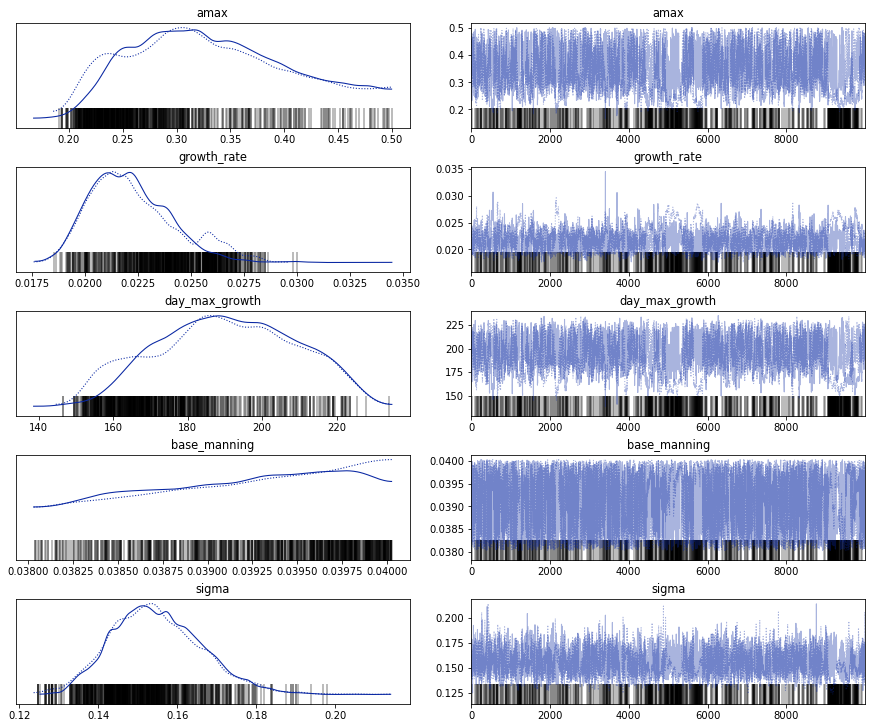

In [34]:
pm.traceplot(traces[0]['2005'])


### The posterior predictive distribution
The posterior predictive distribution is the SRM model, given the posterior distributions of its parameters. Let's see to what extend the model follows the measurements

2015: n_b = 0.039
2015: n_b = 0.039
2015: n_b = 0.039
2015: n_b = 0.039
2015: n_b = 0.039
figures saved to file


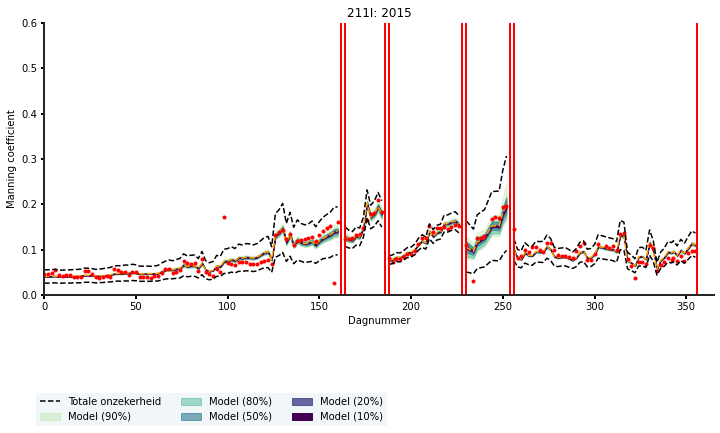

In [35]:
# Run trace through model
def plot_timeseries(year, data, datamasks, traces, output='show'):
    fig = None
    ax = None
    for period_index in range(5):
        
        try:
            if traces[period_index][year] is None:
                continue
            data._mask = datamasks[period_index][year]
        except (IndexError, KeyError):
            continue
        param = SrmParameters()
        param.from_trace(traces[period_index][year])
        sf = FrictionModel(data=data, param=param)
        print (f"{year}: n_b = {np.mean(param.manning):.03f}")
        if ax is None:
            fig, ax = sf.plot()
        else:
            sf.plot(ax=ax)
        
        period = interruptions[case][year][period_index]
        ylim = ax.get_ylim()
        ax.plot([period[0]]*2, ylim, '-r', linewidth=2)
        ax.plot([period[1]]*2, ylim, '-r', linewidth=2)
        
        ax.set_title(f'{case}: {year}')
        ax.set_xlim([0, 365])
    if output=='show':
        return fig, ax
    else:
        plt.savefig(output)
        print ('figures saved to file')

# plot timeseries for a single year (or run this function in loop for all years)
plot_timeseries("2015", data, datamasks, traces, output=f'posterior_predictive_{year}_{case}')


### Visualise posterior distributions


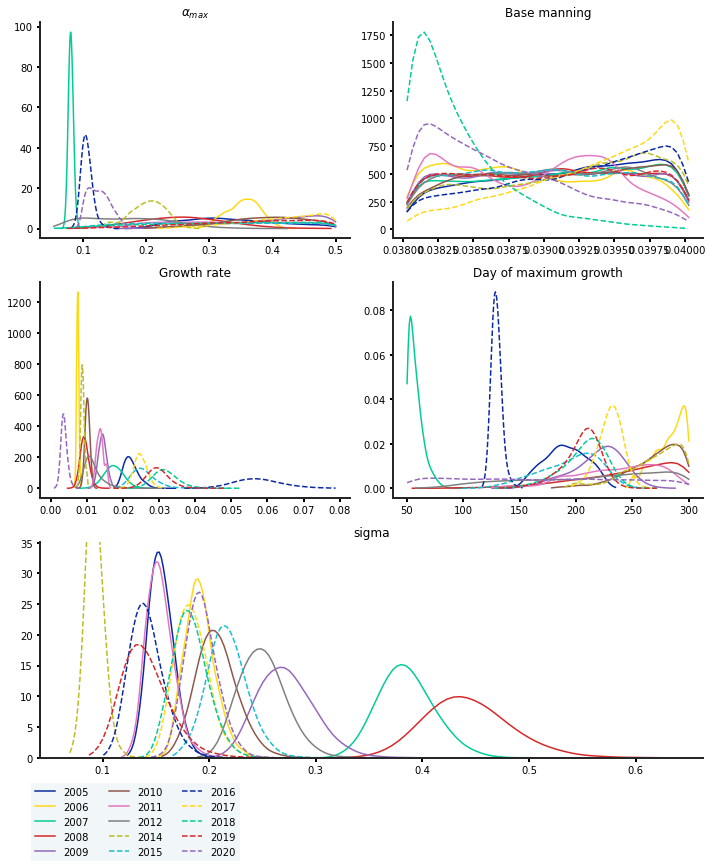

In [40]:
period_index = 0
params = dict()
for year in interruptions[case]:
    params[year] = None
    
for i, year in enumerate(params):
    params[year] = SrmParameters()
    params[year].label = year
    params[year].from_trace(traces[period_index][year])

alts = [params[year] for year in list(interruptions[case].keys())[1:]]
params['2005'].plot(alt=alts)
plt.savefig(f'{year}_distributions.png')

### Compare periods in same year

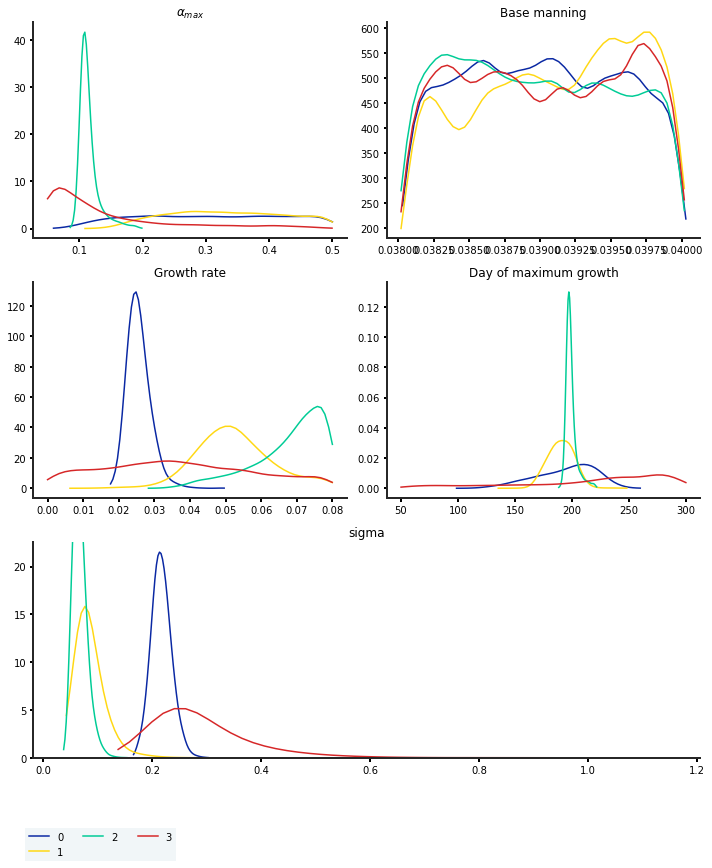

In [42]:
## import matplotlib.pyplot as plt 
year = '2015'
params = dict()
periods = [0, 1, 2, 3]

for period_index in periods:
    try:
        itrace = traces[period_index][year]
        params[period_index] = None
        params[period_index] = SrmParameters()
        params[period_index].label = str(period_index)
        params[period_index].from_trace(itrace)
    except KeyError:
        pass

alts = [params[period_index] for period_index in range(1, len(params))]

params[0].plot(alt=alts)
plt.savefig('distributions_periods.png')


### Joint distributions

Text(0, 0.5, '$\\sigma$')

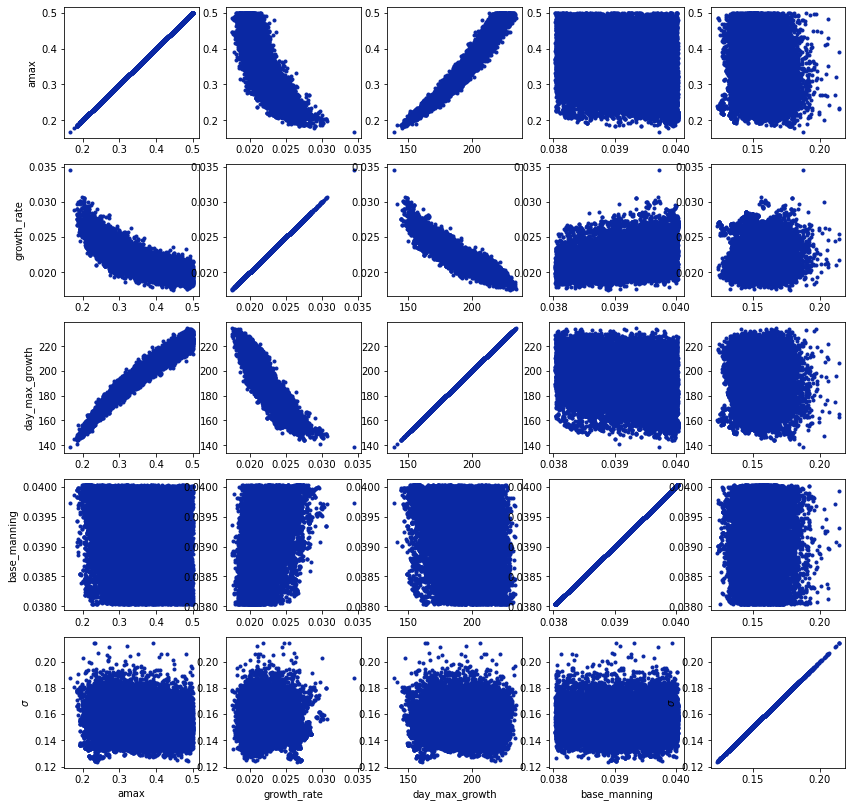

In [43]:
fig, axs = plt.subplots(5, 5, figsize=(14, 14))
for year in ['2005']:
    trace = traces[0][year]
    axs[0][0].plot(trace.amax, trace.amax, '.')
    axs[1][0].plot(trace.amax, trace.growth_rate, '.')
    axs[2][0].plot(trace.amax, trace.day_max_growth, '.')
    axs[3][0].plot(trace.amax, trace.base_manning, '.')
    axs[4][0].plot(trace.amax, trace.sigma, '.')

    axs[0][1].plot(trace.growth_rate, trace.amax, '.')
    axs[1][1].plot(trace.growth_rate, trace.growth_rate, '.')
    axs[2][1].plot(trace.growth_rate, trace.day_max_growth, '.')
    axs[3][1].plot(trace.growth_rate, trace.base_manning, '.')
    axs[4][1].plot(trace.growth_rate, trace.sigma, '.')

    axs[0][2].plot(trace.day_max_growth, trace.amax, '.')
    axs[1][2].plot(trace.day_max_growth, trace.growth_rate, '.')
    axs[2][2].plot(trace.day_max_growth, trace.day_max_growth, '.')
    axs[3][2].plot(trace.day_max_growth, trace.base_manning, '.')
    axs[4][2].plot(trace.day_max_growth, trace.sigma, '.')

    axs[0][3].plot(trace.base_manning, trace.amax, '.')
    axs[1][3].plot(trace.base_manning, trace.growth_rate, '.')
    axs[2][3].plot(trace.base_manning, trace.day_max_growth, '.')
    axs[3][3].plot(trace.base_manning, trace.base_manning, '.')
    axs[4][3].plot(trace.base_manning, trace.sigma, '.')
    
    axs[0][4].plot(trace.sigma, trace.amax, '.')
    axs[1][4].plot(trace.sigma, trace.growth_rate, '.')
    axs[2][4].plot(trace.sigma, trace.day_max_growth, '.')
    axs[3][4].plot(trace.sigma, trace.base_manning, '.')
    axs[4][4].plot(trace.sigma, trace.sigma, '.')
    
axs[0][0].set_ylabel('amax')
axs[1][0].set_ylabel('growth_rate')
axs[2][0].set_ylabel('day_max_growth')
axs[3][0].set_ylabel('base_manning')
axs[4][0].set_ylabel('$\sigma$')

axs[4][0].set_xlabel('amax')
axs[4][1].set_xlabel('growth_rate')
axs[4][2].set_xlabel('day_max_growth')
axs[4][3].set_xlabel('base_manning')
axs[4][4].set_ylabel('$\sigma$')

## Study parameter values

### Growth rates

2005: tmax [172.32971067783993, 209.09319830300674]
2005: tmax [253.41516998131056, 258.97997597281653]
2009: tmax [196.45068265516102, 242.14454912215837]
2009: tmax [49.8101490139627, 196.02848476876107]
2017: tmax [219.38717507551723, 241.1440304601549]
2017: tmax [138.95888867671442, 263.3479704118025]
2017: tmax [185.93470533029142, 310.64578881427906]


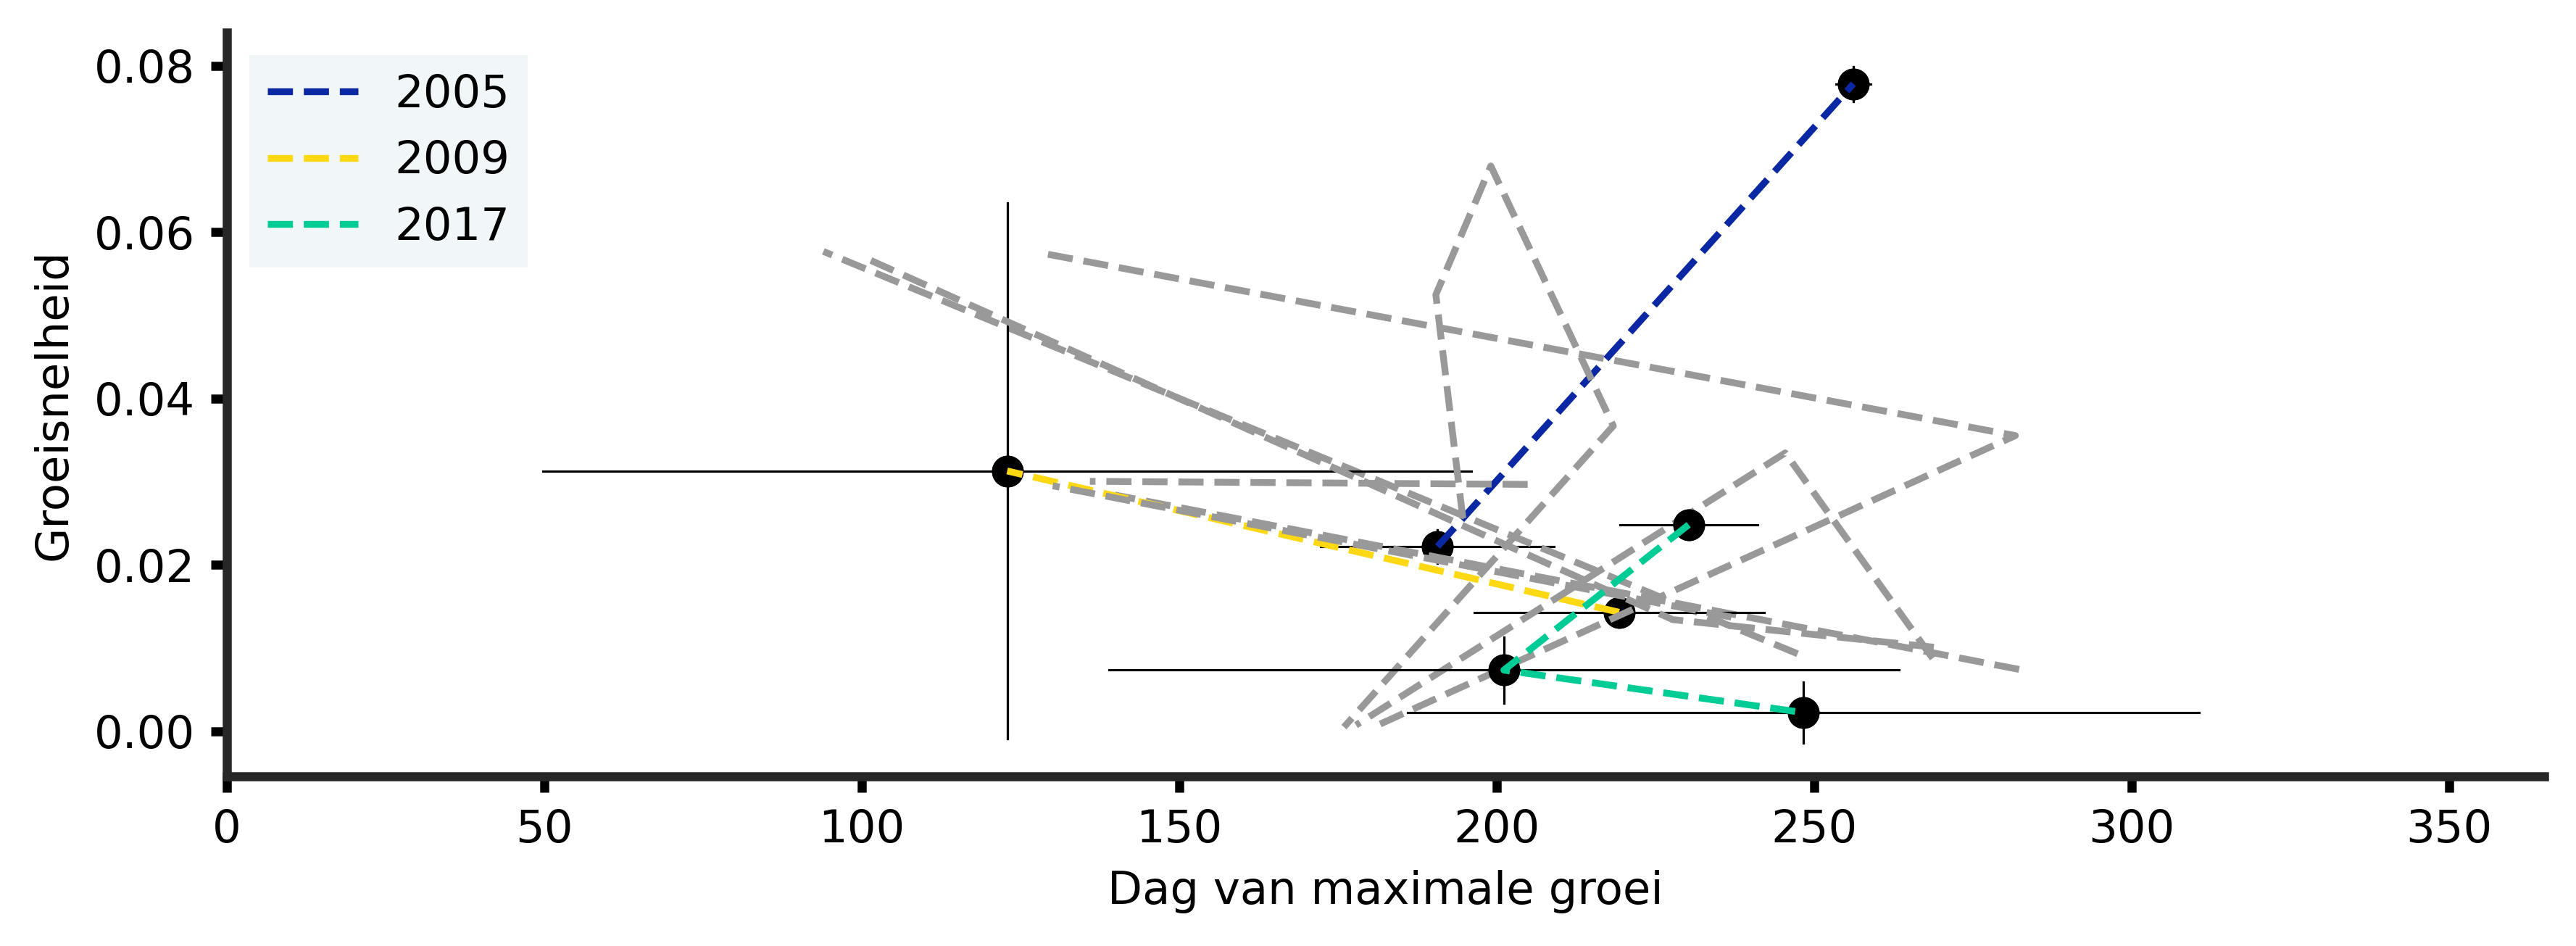

In [44]:
fig, ax = plt.subplots(1, figsize=(8, 3), dpi=450)
selected_years = ["2009", "2017", "2005"]  # shown with color
for year in interruptions[case]:# ['2006', '2009', '2010', '2011', '2015', '2017']:
    x = []
    y = []
    for period in [0, 1, 2, 3, 4, 5]:
        try:
            mean = np.mean(traces[period][year].growth_rate)
            std = np.std(traces[period][year].growth_rate)
            
            meanx = np.mean(traces[period][year].day_max_growth)
            stdx = np.std(traces[period][year].day_max_growth)
            
            #xperiod = interruptions[year][period]
            xperiod = [meanx] * 2
            #xperiod = [period] * 2
            yperiod = [mean]*2
            x.extend(xperiod)
            y.extend(yperiod)
            if year in selected_years:
                ax.plot(xperiod, yperiod, 'o-k', linewidth=1)
                ax.plot([xperiod]*2, [mean-std, mean+std], '-k', linewidth=0.5)
                ax.plot([meanx-stdx, meanx+stdx], [mean]*2, '-k', linewidth=0.5)
                print (f"{year}: tmax [{meanx-stdx}, {meanx+stdx}]")
        except (IndexError, KeyError, AttributeError):
            pass
    #y = np.array(y)
    #y = y - y[0]
    if year in selected_years:#['2006', '2009', '2010', '2011', '2015', '2017']:
        ax.plot(x, y, '--', label=year)
        
    else:
        ax.plot(x, y, '--', color=[0.6]*3)
ax.set_xlim([0, 365])    
ax.legend()
ax.set_xlabel('Dag van maximale groei')
ax.set_ylabel('Groeisnelheid')
SetPlotStyle(fig, legendbelow=False)
plt.tight_layout()
plt.savefig(f'{case}_Groeisnelheid')

### Base roughness

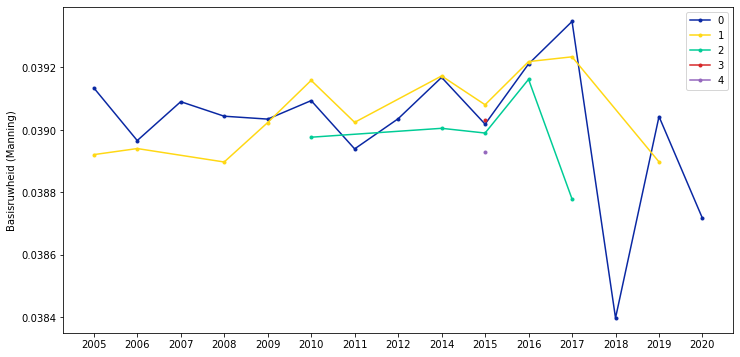

In [45]:
fig, ax = plt.subplots(1, figsize=(12, 6))

for period in (0, 1, 2, 3, 4):
    x = []
    y = []
    for year in interruptions[case]:   
        try:
            mean = np.mean(traces[period][year].base_manning)
            std = np.std(traces[period][year].base_manning)
            #print(f"{year}:{mean:3.0f} +/- {std:3.0f}")
            x.append(year)
            y.append(mean)

        except (IndexError, KeyError):
            pass

    ax.plot(x, y, '.-',label=period)
ax.set_ylabel('Basisruwheid (Manning)')
ax.legend()